In [1]:
import pandas as pd
import numpy as np
import holidays
import datetime
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') 

import os
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import random
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [2]:
building = pd.read_csv('building_info.csv')
building = building.replace('-', 'NaN')
building = building.astype({'태양광용량(kW)' : 'float', 'ESS저장용량(kWh)' : 'float', 'PCS용량(kW)' : 'float'})

In [3]:
train = pd.read_csv('train.csv')
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))
train['일시'] = train['일시'].str.replace(' ', '').astype('str')
train['일시'] = train['일시'] + str('00')
train['일시'] = pd.to_datetime(train['일시'])

In [4]:
train['weekend'] = train['일시'].dt.weekday

In [5]:
# 평일 = 0, 공휴일 = 1
kr_holidays = holidays.Korea(years=train['일시'].dt.year.unique())
train['평일'] = train['일시'].apply(lambda x: 1 if x.weekday() >= 5 or x in kr_holidays else 0)

In [6]:
train = pd.merge(left = train , right = building, how = "inner", on = "건물번호")

In [7]:
train = train.set_index('일시')

In [8]:
# 일사량 결측치 처리
a = [0, 1, 2, 3, 4, 5, 6,20,21,22,23]
for i in a:
    train.loc[train['time'] == i, '일사(MJ/m2)'] = train.loc[train['time'] == i, '일사(MJ/m2)'].fillna(0)

In [9]:
train['일사(MJ/m2)'] = train['일사(MJ/m2)'].interpolate()

In [10]:
# 일조량 결측치 처리
# 일사량 결측치 처리
a = [0, 1, 2, 3, 4, 5, 6,20,21,22,23]
for i in a:
    train.loc[train['time'] == i, '일조(hr)'] = train.loc[train['time'] == i, '일조(hr)'].fillna(0)

In [11]:
train['일조(hr)'] = train['일조(hr)'].interpolate()
train['습도(%)'] = train['습도(%)'].interpolate()
train['풍속(m/s)'] = train['풍속(m/s)'].interpolate()

In [12]:
test = pd.read_csv('test.csv')
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))
test['일시'] = test['일시'].str.replace(' ', '').astype('str')
test['일시'] = test['일시'] + str('00')
test['일시'] = pd.to_datetime(test['일시'])
# 평일 = 0, 공휴일 = 1
kr_holidays = holidays.Korea(years=test['일시'].dt.year.unique())
test['평일'] = test['일시'].apply(lambda x: 1 if x.weekday() >= 5 or x in kr_holidays else 0)
test['weekend'] = test['일시'].dt.weekday

In [13]:
test = pd.merge(left = test , right = building, how = "inner", on = "건물번호")
test = test.set_index('일시')

In [14]:
building['건물유형'].value_counts()

건물기타       15
공공          8
대학교         8
백화점및아울렛     8
병원          8
상용          8
아파트         8
연구소         8
지식산업센터      8
할인마트        8
호텔및리조트      8
데이터센터       5
Name: 건물유형, dtype: int64

In [15]:
building[building['건물유형'] == '데이터센터']

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
31,32,데이터센터,35300.00,14687.00,NaN,NaN,NaN
32,33,데이터센터,28059.00,20397.00,NaN,NaN,NaN
33,34,데이터센터,10665.00,9402.00,NaN,NaN,NaN
34,35,데이터센터,9736.00,6070.00,NaN,NaN,NaN
35,36,데이터센터,8816.49,8816.49,NaN,NaN,NaN


In [16]:
building[building['건물유형'] == '건물기타']

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,NaN,NaN,NaN
1,2,건물기타,122233.47,99000.00,NaN,NaN,NaN
2,3,건물기타,171243.00,113950.00,40.0,NaN,NaN
3,4,건물기타,74312.98,34419.62,60.0,NaN,NaN
4,5,건물기타,205884.00,150000.00,NaN,2557.0,1000.0
5,6,건물기타,205754.00,74565.00,NaN,NaN,NaN
6,7,건물기타,101711.52,41341.10,NaN,800.0,300.0
7,8,건물기타,75344.54,24117.00,NaN,NaN,NaN
8,9,건물기타,222882.35,15651.18,NaN,NaN,NaN
9,10,건물기타,31062.00,18637.00,NaN,NaN,NaN


In [17]:
building[building['건물유형'] == '공공']

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
15,16,공공,240038.00,95175.00,20.0,NaN,NaN
16,17,공공,66467.00,46896.00,NaN,NaN,NaN
17,18,공공,75624.56,39915.10,64.8,NaN,NaN
18,19,공공,90730.40,90730.00,NaN,1362.0,500.0
19,20,공공,12872877.00,10941945.00,NaN,NaN,NaN
20,21,공공,61469.67,43970.64,70.0,837.1,500.0
21,22,공공,61375.47,19800.00,110.0,NaN,NaN
22,23,공공,32236.11,16565.00,NaN,NaN,NaN


In [18]:
building[building['건물유형'] == '대학교']

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
23,24,대학교,659696.910,516097.85,97.65,NaN,NaN
24,25,대학교,528014.050,369812.24,50.00,NaN,NaN
25,26,대학교,386466.900,162020.00,26.64,NaN,NaN
26,27,대학교,578484.113,501381.53,30.00,NaN,NaN
27,28,대학교,249494.000,130520.00,50.00,NaN,NaN
28,29,대학교,199623.000,77202.00,25.00,NaN,NaN
29,30,대학교,155785.000,106305.00,20.00,NaN,NaN
30,31,대학교,201781.000,119836.00,83.72,NaN,NaN


In [19]:
building[building['건물유형'] == '대학교'].corr()

,건물번호,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
건물번호,1.000000,-0.883752,-0.746258,-0.234612,NaN,NaN
연면적(m2),-0.883752,1.000000,0.960332,0.358850,NaN,NaN
냉방면적(m2),-0.746258,0.960332,1.000000,0.373287,NaN,NaN
태양광용량(kW),-0.234612,0.358850,0.373287,1.000000,NaN,NaN
ESS저장용량(kWh),NaN,NaN,NaN,NaN,NaN,NaN
PCS용량(kW),NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
building[building['건물유형'] == '병원']

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
44,45,병원,86787.03,70579.00,NaN,NaN,NaN
45,46,병원,85869.49,78675.00,100.56,NaN,NaN
46,47,병원,191624.00,163255.00,NaN,NaN,NaN
47,48,병원,66729.00,50000.00,200.00,NaN,NaN
48,49,병원,112953.61,70301.00,46.20,NaN,NaN
49,50,병원,91967.00,75836.00,3.00,NaN,NaN
50,51,병원,88242.76,80566.00,NaN,NaN,NaN
51,52,병원,91634.21,69227.19,25.00,NaN,NaN


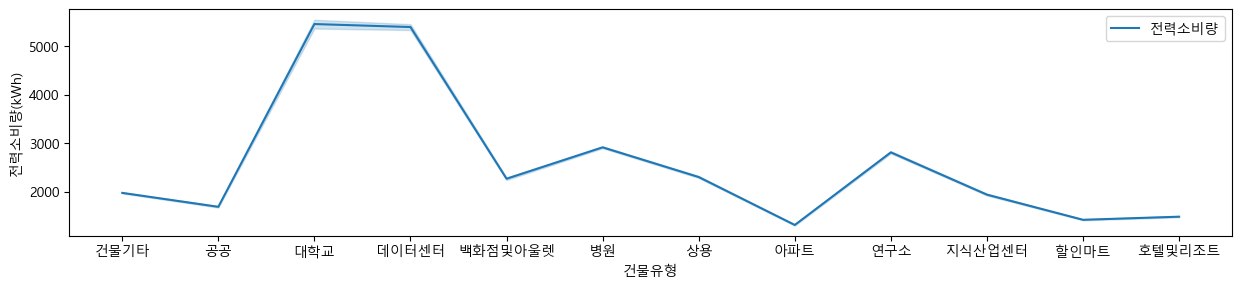

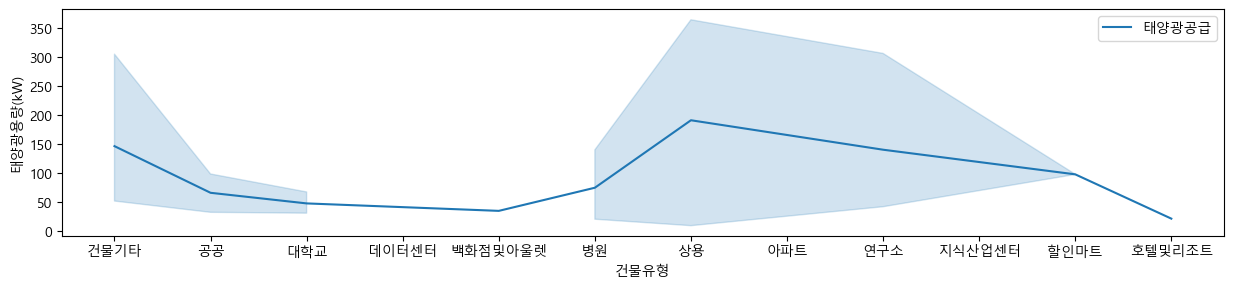

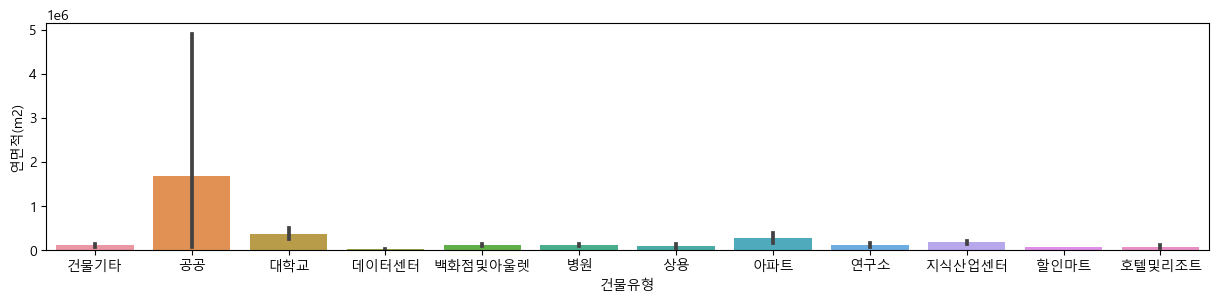

In [21]:
plt.figure(figsize = (15, 10))
plt.subplot(3, 1, 1)
sns.lineplot(x = '건물유형', y = '전력소비량(kWh)', data = train[['건물유형', '전력소비량(kWh)']])
plt.legend(['전력소비량'])
plt.show()

plt.figure(figsize = (15, 10))
plt.subplot(3, 1, 2)
sns.lineplot(x = '건물유형', y = '태양광용량(kW)', data = building)
plt.legend(['태양광공급'])
plt.show()

plt.figure(figsize = (15, 10))
plt.subplot(3, 1, 3)
sns.barplot(x = building['건물유형'], y = building['연면적(m2)'])
plt.show()

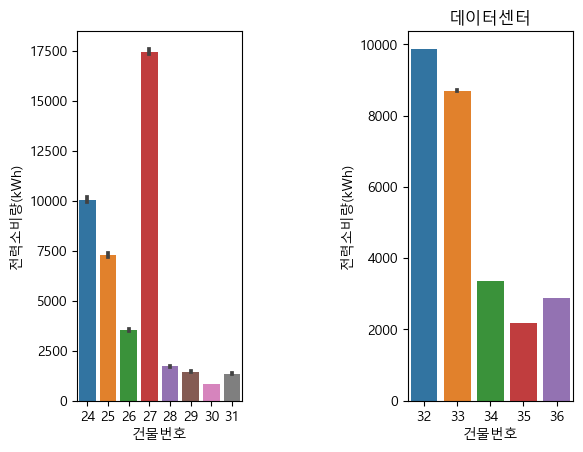

In [22]:
uni = train[train['건물유형'].str.contains('대학교')]
data = train[train['건물유형'].str.contains('데이터센터')]

plt.subplots_adjust(wspace=1)
plt.title('대학교')
plt.subplot(1, 2, 1)
sns.barplot(x = uni['건물번호'], y = uni['전력소비량(kWh)'])

plt.subplot(1, 2, 2)
plt.title("데이터센터")
sns.barplot(x = data['건물번호'], y = data['전력소비량(kWh)'])
plt.show()

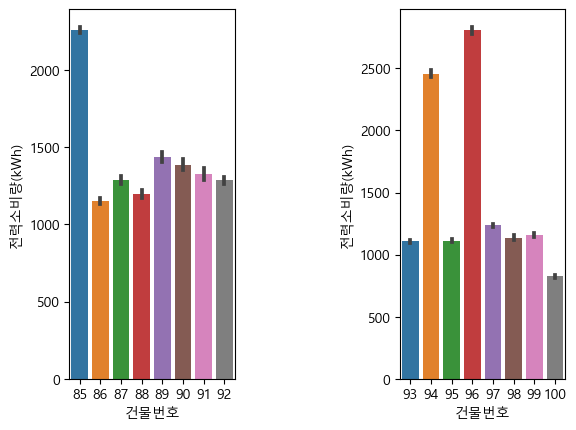

In [23]:
mart = train[train['건물유형'].str.contains('할인마트')]
hotel = train[train['건물유형'].str.contains('호텔및리조트')]

plt.subplots_adjust(wspace=1)
plt.subplot(1, 2, 1)
sns.barplot(x = mart['건물번호'], y = mart['전력소비량(kWh)'])

plt.subplot(1, 2, 2)
sns.barplot(x = hotel['건물번호'], y = hotel['전력소비량(kWh)'])
plt.show()

In [24]:
building[building['건물유형'].str.contains('대학교|데이터센터')]

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
23,24,대학교,659696.910,516097.85,97.65,NaN,NaN
24,25,대학교,528014.050,369812.24,50.00,NaN,NaN
25,26,대학교,386466.900,162020.00,26.64,NaN,NaN
26,27,대학교,578484.113,501381.53,30.00,NaN,NaN
27,28,대학교,249494.000,130520.00,50.00,NaN,NaN
28,29,대학교,199623.000,77202.00,25.00,NaN,NaN
29,30,대학교,155785.000,106305.00,20.00,NaN,NaN
30,31,대학교,201781.000,119836.00,83.72,NaN,NaN
31,32,데이터센터,35300.000,14687.00,NaN,NaN,NaN
32,33,데이터센터,28059.000,20397.00,NaN,NaN,NaN


In [25]:
building[building['건물유형'].str.contains('아파트|할인마트|호텔및리조트')]

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
60,61,아파트,667131.000,539213.00,NaN,NaN,NaN
61,62,아파트,233187.000,178666.00,NaN,NaN,NaN
62,63,아파트,187737.000,158300.00,NaN,NaN,NaN
63,64,아파트,240551.000,198767.00,NaN,NaN,NaN
64,65,아파트,183839.000,0.00,NaN,NaN,NaN
65,66,아파트,105073.000,0.00,NaN,NaN,NaN
66,67,아파트,85244.000,59671.00,NaN,NaN,NaN
67,68,아파트,389395.928,0.00,NaN,NaN,NaN
84,85,할인마트,71591.000,35000.00,NaN,NaN,NaN
85,86,할인마트,54866.510,30953.00,97.85,NaN,NaN


Text(0.5, 1.0, '전력소비량(kWh)')

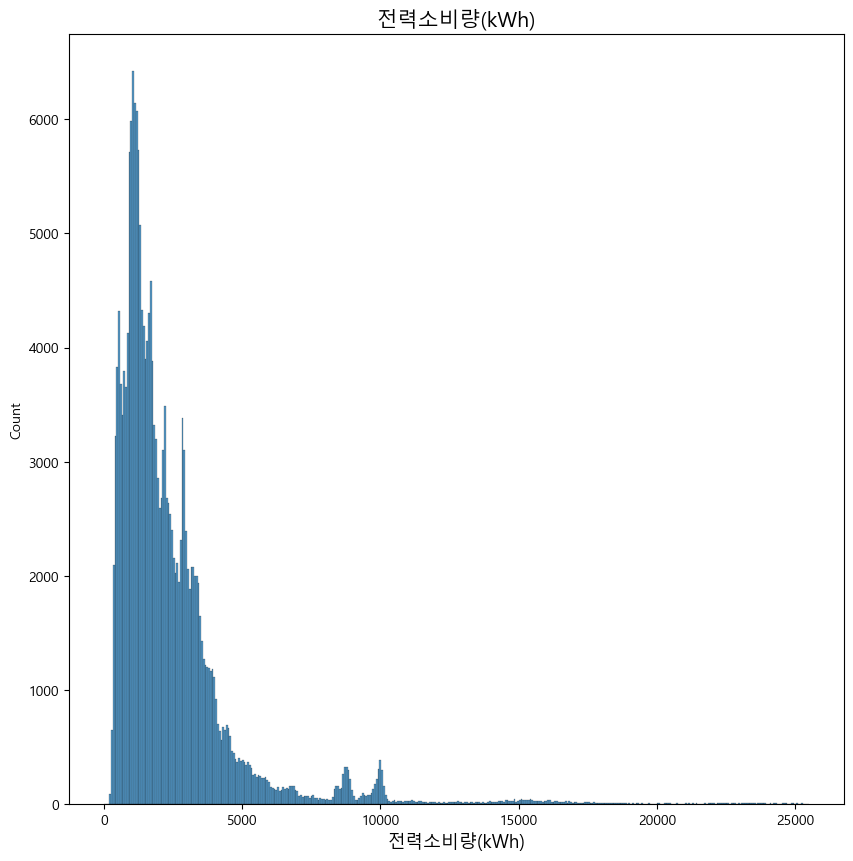

In [26]:
plt.figure(figsize=(10,10))
sns.histplot(data=train,x='전력소비량(kWh)')
plt.xlabel('전력소비량(kWh)',fontsize=13)
plt.title('전력소비량(kWh)',fontsize=15)

In [27]:
power_bins = [0, 5000, 10000, 15000, 20000, float('inf')]
labels = [1, 2, 3, 4, 5]
train['범위'] = pd.cut(train['전력소비량(kWh)'], bins=power_bins, labels=labels)

In [28]:
train

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,time,weekend,평일,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),범위
일시,,,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,1_20220601 00,1,18.6,NaN,0.9,42.0,0.0,0.0,1085.28,6,1,0,2,0,건물기타,110634.00,39570.00,NaN,NaN,NaN,1
2022-06-01 01:00:00,1_20220601 01,1,18.0,NaN,1.1,45.0,0.0,0.0,1047.36,6,1,1,2,0,건물기타,110634.00,39570.00,NaN,NaN,NaN,1
2022-06-01 02:00:00,1_20220601 02,1,17.7,NaN,1.5,45.0,0.0,0.0,974.88,6,1,2,2,0,건물기타,110634.00,39570.00,NaN,NaN,NaN,1
2022-06-01 03:00:00,1_20220601 03,1,16.7,NaN,1.4,48.0,0.0,0.0,953.76,6,1,3,2,0,건물기타,110634.00,39570.00,NaN,NaN,NaN,1
2022-06-01 04:00:00,1_20220601 04,1,18.4,NaN,2.8,43.0,0.0,0.0,986.40,6,1,4,2,0,건물기타,110634.00,39570.00,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24 19:00:00,100_20220824 19,100,23.1,NaN,0.9,86.0,0.5,0.0,881.04,8,24,19,2,0,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1
2022-08-24 20:00:00,100_20220824 20,100,22.4,NaN,1.3,86.0,0.0,0.0,798.96,8,24,20,2,0,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1
2022-08-24 21:00:00,100_20220824 21,100,21.3,NaN,1.0,92.0,0.0,0.0,825.12,8,24,21,2,0,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1


<Axes: xlabel='범위', ylabel='count'>

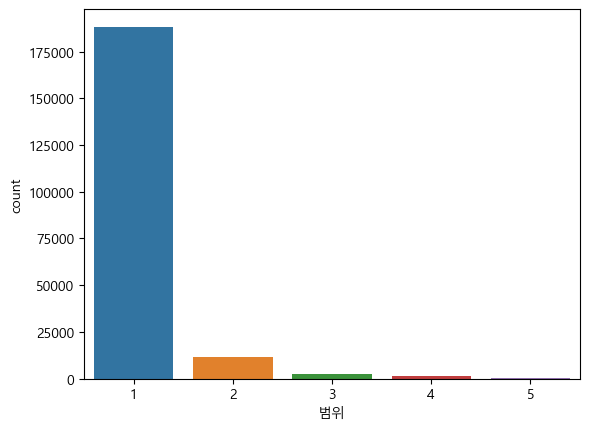

In [29]:
sns.countplot(data = train, x = '범위')

In [30]:
train.isnull().sum() / len(train)

num_date_time    0.000000
건물번호             0.000000
기온(C)            0.000000
강수량(mm)          0.784652
풍속(m/s)          0.000000
습도(%)            0.000000
일조(hr)           0.000000
일사(MJ/m2)        0.000000
전력소비량(kWh)       0.000000
month            0.000000
day              0.000000
time             0.000000
weekend          0.000000
평일               0.000000
건물유형             0.000000
연면적(m2)          0.000000
냉방면적(m2)         0.000000
태양광용량(kW)        0.640000
ESS저장용량(kWh)     0.950000
PCS용량(kW)        0.950000
범위               0.000005
dtype: float64

In [31]:
train[['일조(hr)', '일사(MJ/m2)', '강수량(mm)', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)']].dropna().corr()

,일조(hr),일사(MJ/m2),강수량(mm),기온(C),풍속(m/s),습도(%),전력소비량(kWh)
일조(hr),1.000000,0.728284,-0.080896,0.253580,0.027523,-0.441173,0.074565
일사(MJ/m2),0.728284,1.000000,-0.142142,0.308950,0.062597,-0.490539,0.172128
강수량(mm),-0.080896,-0.142142,1.000000,-0.066500,0.028724,0.271468,0.015386
기온(C),0.253580,0.308950,-0.066500,1.000000,0.138078,-0.319698,0.138628
풍속(m/s),0.027523,0.062597,0.028724,0.138078,1.000000,-0.084895,0.072105
습도(%),-0.441173,-0.490539,0.271468,-0.319698,-0.084895,1.000000,-0.095564
전력소비량(kWh),0.074565,0.172128,0.015386,0.138628,0.072105,-0.095564,1.000000


<Axes: xlabel='month', ylabel='전력소비량(kWh)'>

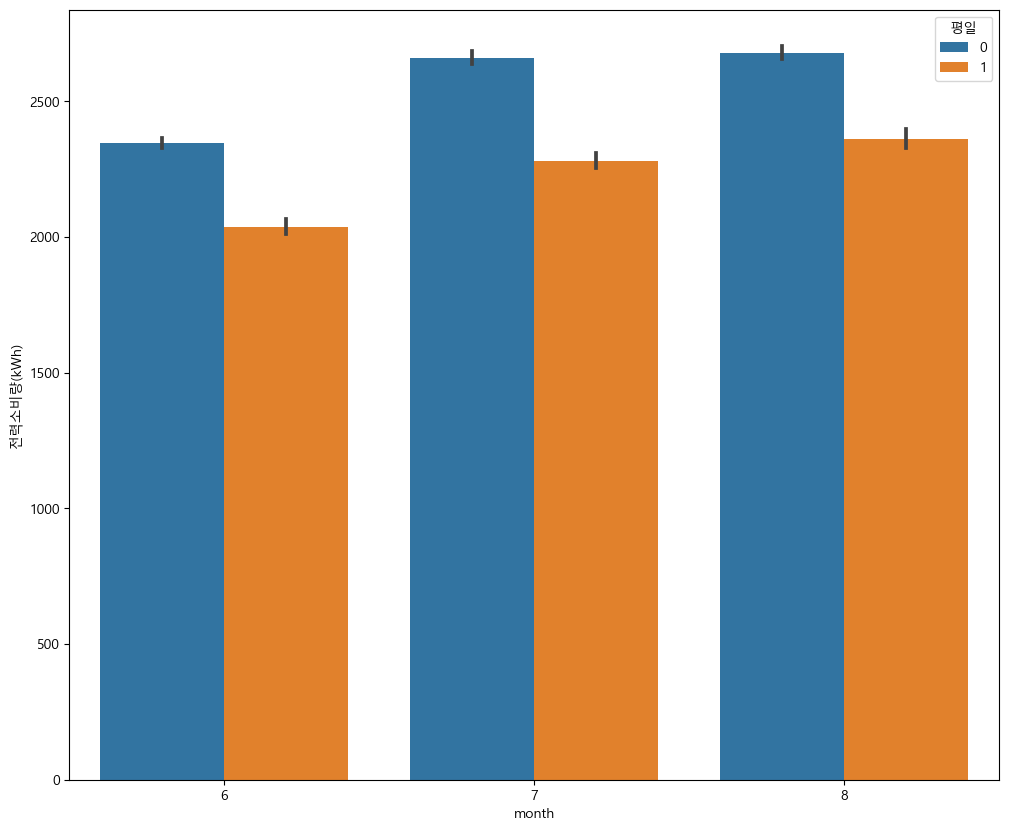

In [32]:
plt.figure(figsize = (12, 10))
sns.barplot(x = train['month'], y = train['전력소비량(kWh)'], hue = train['평일'])

<Axes: xlabel='day', ylabel='전력소비량(kWh)'>

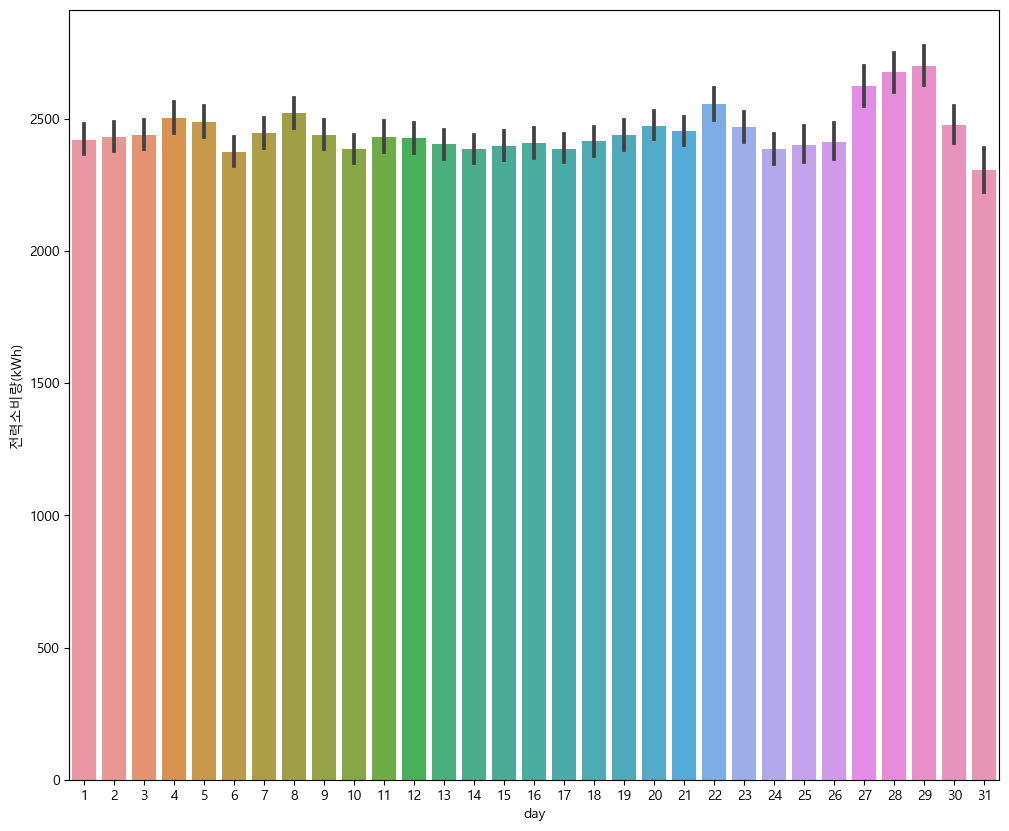

In [33]:
plt.figure(figsize = (12, 10))
sns.barplot(x = train['day'], y = train['전력소비량(kWh)'])

<Axes: xlabel='time', ylabel='전력소비량(kWh)'>

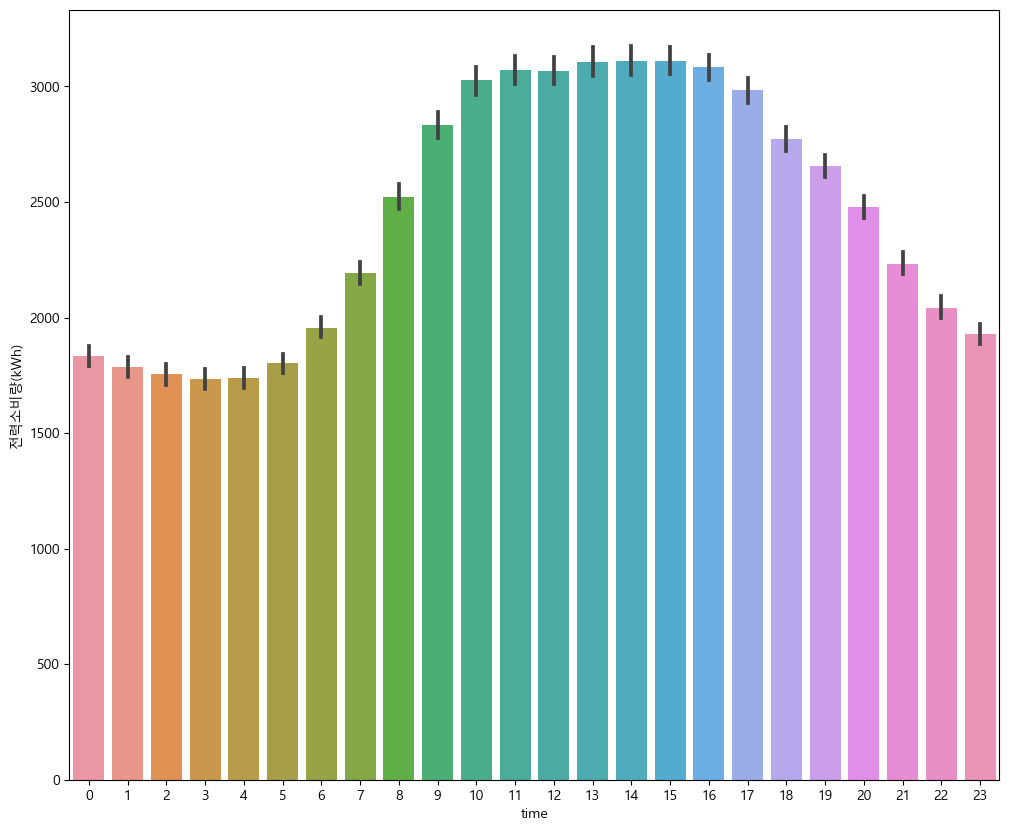

In [34]:
plt.figure(figsize = (12, 10))
sns.barplot(x = train['time'], y = train['전력소비량(kWh)'])

<Axes: xlabel='time', ylabel='전력소비량(kWh)'>

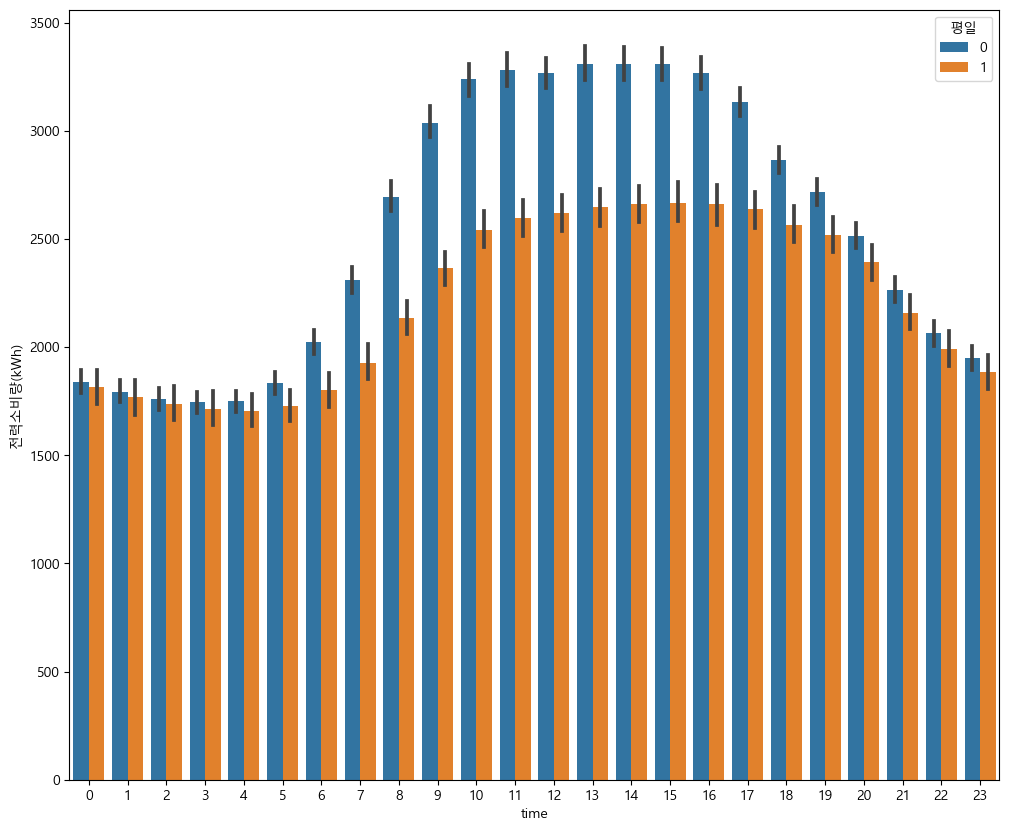

In [35]:
plt.figure(figsize = (12, 10))
sns.barplot(x = train['time'], y = train['전력소비량(kWh)'], hue = train['평일'])

In [36]:
new_building = building.drop('태양광용량(kW)', axis = 1)
new_building

,건물번호,건물유형,연면적(m2),냉방면적(m2),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,1.106340e+05,39570.00,NaN,NaN
1,2,건물기타,1.222335e+05,99000.00,NaN,NaN
2,3,건물기타,1.712430e+05,113950.00,NaN,NaN
3,4,건물기타,7.431298e+04,34419.62,NaN,NaN
4,5,건물기타,2.058840e+05,150000.00,2557.0,1000.0
5,6,건물기타,2.057540e+05,74565.00,NaN,NaN
6,7,건물기타,1.017115e+05,41341.10,800.0,300.0
7,8,건물기타,7.534454e+04,24117.00,NaN,NaN
8,9,건물기타,2.228824e+05,15651.18,NaN,NaN
9,10,건물기타,3.106200e+04,18637.00,NaN,NaN


In [37]:
new_building.dropna(inplace = True)

In [38]:
new_building

,건물번호,건물유형,연면적(m2),냉방면적(m2),ESS저장용량(kWh),PCS용량(kW)
4,5,건물기타,205884.00,150000.00,2557.0,1000.0
6,7,건물기타,101711.52,41341.10,800.0,300.0
18,19,공공,90730.40,90730.00,1362.0,500.0
20,21,공공,61469.67,43970.64,837.1,500.0
70,71,연구소,90896.00,44536.00,3100.0,800.0


In [39]:
new_building.iloc[:, 2 : ].corr()

,연면적(m2),냉방면적(m2),ESS저장용량(kWh),PCS용량(kW)
연면적(m2),1.000000,0.883076,0.479462,0.709830
냉방면적(m2),0.883076,1.000000,0.373425,0.680692
ESS저장용량(kWh),0.479462,0.373425,1.000000,0.871529
PCS용량(kW),0.709830,0.680692,0.871529,1.000000


<Axes: xlabel='일시'>

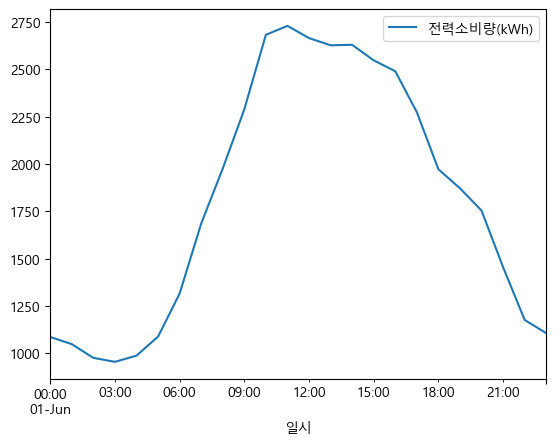

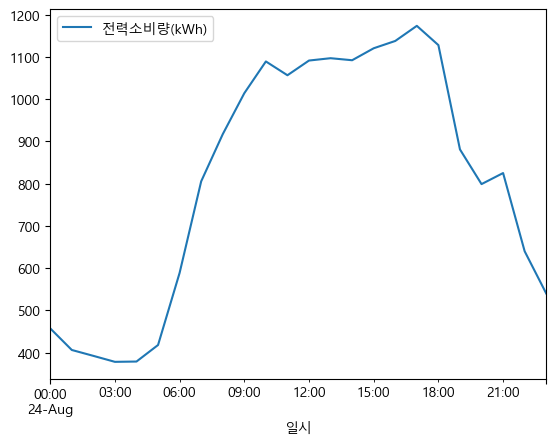

In [40]:
train.head(24).plot(y = '전력소비량(kWh)')
train.tail(24).plot(y = '전력소비량(kWh)')

In [41]:
# train['일조(hr)'].fillna(0, inplace = True)
# train['일사(MJ/m2)'].fillna(0, inplace = True)

In [42]:
weather = train.iloc[train.shape[0] - test.shape[0] : , :]
test['일사(MJ/m2)'] = weather['일사(MJ/m2)'].values

In [43]:
train = train[['num_date_time', '건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', 'month', 'day', 'time', '평일', 'weekend',
       '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)', '범위', '전력소비량(kWh)',]]

In [44]:
test = test[['num_date_time', '건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
        '일사(MJ/m2)', 'month', 'day', 'time', '평일', 'weekend',
       '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)']]

In [45]:
train.isnull().sum()

num_date_time         0
건물번호                  0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)               0
습도(%)                 0
일조(hr)                0
일사(MJ/m2)             0
month                 0
day                   0
time                  0
평일                    0
weekend               0
건물유형                  0
연면적(m2)               0
냉방면적(m2)              0
태양광용량(kW)        130560
ESS저장용량(kWh)     193800
PCS용량(kW)        193800
범위                    1
전력소비량(kWh)            0
dtype: int64

In [50]:
train[['기온(C)', '풍속(m/s)', '습도(%)']]

,기온(C),풍속(m/s),습도(%)
일시,,,
2022-06-01 00:00:00,18.6,0.9,42.0
2022-06-01 01:00:00,18.0,1.1,45.0
2022-06-01 02:00:00,17.7,1.5,45.0
2022-06-01 03:00:00,16.7,1.4,48.0
2022-06-01 04:00:00,18.4,2.8,43.0
...,...,...,...
2022-08-24 19:00:00,23.1,0.9,86.0
2022-08-24 20:00:00,22.4,1.3,86.0
2022-08-24 21:00:00,21.3,1.0,92.0


In [51]:
train['mean'] = train[['기온(C)', '풍속(m/s)', '습도(%)']].mean(axis= 1)
train['std'] = train[['기온(C)', '풍속(m/s)', '습도(%)']].std(axis = 1)
train

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),month,day,time,평일,weekend,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),범위,전력소비량(kWh),mean,std
일시,,,,,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,1_20220601 00,1,18.6,NaN,0.9,42.0,0.0,0.0,6,1,0,0,2,건물기타,110634.00,39570.00,NaN,NaN,NaN,1,1085.28,20.500000,20.615771
2022-06-01 01:00:00,1_20220601 01,1,18.0,NaN,1.1,45.0,0.0,0.0,6,1,1,0,2,건물기타,110634.00,39570.00,NaN,NaN,NaN,1,1047.36,21.366667,22.142794
2022-06-01 02:00:00,1_20220601 02,1,17.7,NaN,1.5,45.0,0.0,0.0,6,1,2,0,2,건물기타,110634.00,39570.00,NaN,NaN,NaN,1,974.88,21.400000,21.984767
2022-06-01 03:00:00,1_20220601 03,1,16.7,NaN,1.4,48.0,0.0,0.0,6,1,3,0,2,건물기타,110634.00,39570.00,NaN,NaN,NaN,1,953.76,22.033333,23.753386
2022-06-01 04:00:00,1_20220601 04,1,18.4,NaN,2.8,43.0,0.0,0.0,6,1,4,0,2,건물기타,110634.00,39570.00,NaN,NaN,NaN,1,986.40,21.400000,20.267215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24 19:00:00,100_20220824 19,100,23.1,NaN,0.9,86.0,0.5,0.0,8,24,19,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1,881.04,36.666667,44.142308
2022-08-24 20:00:00,100_20220824 20,100,22.4,NaN,1.3,86.0,0.0,0.0,8,24,20,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1,798.96,36.566667,44.091307
2022-08-24 21:00:00,100_20220824 21,100,21.3,NaN,1.0,92.0,0.0,0.0,8,24,21,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,1,825.12,38.100000,47.769551


In [52]:
test['mean'] = test[['기온(C)', '풍속(m/s)', '습도(%)']].mean(axis= 1)
test['std'] = test[['기온(C)', '풍속(m/s)', '습도(%)']].std(axis = 1)
test

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일사(MJ/m2),month,day,time,평일,weekend,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),mean,std
일시,,,,,,,,,,,,,,,,,,,,
2022-08-25 00:00:00,1_20220825 00,1,23.5,0.0,2.2,72,0.0,8,25,0,0,3,건물기타,110634.00,39570.00,NaN,NaN,NaN,32.566667,35.772382
2022-08-25 01:00:00,1_20220825 01,1,23.0,0.0,0.9,72,0.0,8,25,1,0,3,건물기타,110634.00,39570.00,NaN,NaN,NaN,31.966667,36.388231
2022-08-25 02:00:00,1_20220825 02,1,22.7,0.0,1.5,75,0.0,8,25,2,0,3,건물기타,110634.00,39570.00,NaN,NaN,NaN,33.066667,37.830719
2022-08-25 03:00:00,1_20220825 03,1,22.1,0.0,1.3,78,0.0,8,25,3,0,3,건물기타,110634.00,39570.00,NaN,NaN,NaN,33.800000,39.665980
2022-08-25 04:00:00,1_20220825 04,1,21.8,0.0,1.0,77,0.0,8,25,4,0,3,건물기타,110634.00,39570.00,NaN,NaN,NaN,33.266667,39.276117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,100_20220831 19,100,22.5,0.0,0.9,84,0.0,8,31,19,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,35.800000,43.116934
2022-08-31 20:00:00,100_20220831 20,100,20.7,0.0,0.4,95,0.0,8,31,20,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,38.700000,49.802510
2022-08-31 21:00:00,100_20220831 21,100,20.2,0.0,0.4,98,0.0,8,31,21,0,2,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN,39.533333,51.592377


In [121]:
import shap

X = train[['기온(C)', '강수량(mm)', '습도(%)', '일조(hr)', '일사(MJ/m2)']]
Y = train['전력소비량(kWh)']

In [122]:
model = lgb.LGBMRegressor().fit(X, Y)

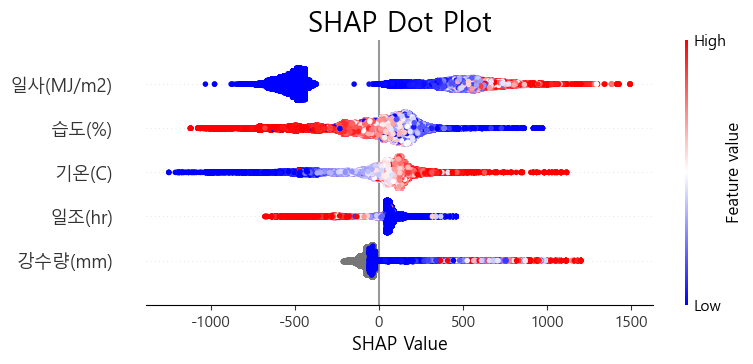

In [123]:
tree_explainer = shap.TreeExplainer(model) ## TreeExplainer 객체 생성
shap_values = tree_explainer.shap_values(X) ## SHAP Value
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X, 
                  feature_names = X.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

In [53]:
sub = pd.read_csv('sample_submission.csv')

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error

## 모델은 여기서 수정가능 

In [71]:
class run:
    def __init__(self, train, test, n, col_name1, col_name2, window_size):
        self.train = train
        self.test = test
        self.n = n
        self.col_name1 = col_name1
        self.col_name2 = col_name2
        self.window_size = window_size
        
    def make_table(self):
        train = self.train
        n = self.n
        test = self.test
        train_table = train[train['건물번호'] == n]
        train_table['풍속(m/s)'].fillna(method = 'bfill', inplace = True)
        train_table['습도(%)'].fillna(method = 'bfill', inplace = True)
        train_table = train_table.drop(['강수량(mm)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '일사(MJ/m2)',
                                        '일조(hr)', '연면적(m2)', '냉방면적(m2)', '건물유형', 'num_date_time'], axis = 1)
        

        
        test_table = test[test['건물번호'] == n]
        test_table = test_table.drop(['강수량(mm)', '연면적(m2)', '냉방면적(m2)', '일사(MJ/m2)',
                         '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '건물유형', 'num_date_time'], axis = 1)
        all_table = pd.concat([train_table, test_table])
        return all_table
    
    def window_table(self):
        all_table = self.make_table()
        col_name1 = self.col_name1
        col_name2 = self.col_name2
        window_size = self.window_size
        for i in range(1, window_size + 1):
            col_window_name = col_name1 + "_Window" + str(i)
            all_table[col_window_name] = all_table[col_name1].shift(i)
        for i in range(1, window_size + 1):
            col_window_name = col_name2 + "_Window" + str(i)
            all_table[col_window_name] = all_table[col_name2].shift(i)
        train = all_table.iloc[: 2040, : ]
        test = all_table.iloc[len(train):, :]
        train.dropna(inplace = True)
        train_x = train.drop(['전력소비량(kWh)', '건물번호', '범위'], axis =1)
        train_y = train['전력소비량(kWh)']
        test = test.drop(['전력소비량(kWh)', '건물번호', '범위'], axis =1)
        return train_x, train_y, test
    
    def model(self):
        train_x, train_y, test = self.window_table()
#         model = lgb.LGBMRegressor()
        model = RandomForestRegressor()
        model.fit(train_x, train_y)
        preds = model.predict(test)
        return preds
#         skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 10번의 fold 진행
#         n = 0 

#         fold_target_pred = []
#         fold_score = []

#         for train_index, valid_index in skf.split(train_x, train_x['범위']): 
#             n += 1

#             val_pred_name = [] 
#             val_pred = []      
#             target_pred = []   

#             train_X = np.array(train_x.drop('범위', axis = 1)) 
#             train_Y = np.array(train_y)

#             X_train, X_valid = train_X[train_index], train_X[valid_index]
#             y_train, y_valid = train_Y[train_index], train_Y[valid_index]

#             X_test = np.array(test)

            
#             model = lgb.LGBMRegressor(random_state = 42, verbose = 0) #추가적으로 하이퍼파라미터 튜닝 필요
#             model.fit(X_train, y_train) # 모델 학습

#             val_pred_name.append("LGBMRegressor")      
#             val_pred.append(model.predict(X_valid))   
#             target_pred.append(model.predict(X_test)) 

            
#             model = XGBRegressor(random_state = 42) #추가적으로 하이퍼파라미터 튜닝 필요
#             model.fit(X_train, y_train)

#             val_pred_name.append("XGBRegressor")      
#             val_pred.append(model.predict(X_valid))   
#             target_pred.append(model.predict(X_test)) 

            
#             model = CatBoostRegressor(random_state = 42, verbose = False) #추가적으로 하이퍼파라미터 튜닝 필요
#             model.fit(X_train, y_train)

#             val_pred_name.append("CatBoostRegressor")      
#             val_pred.append(model.predict(X_valid))   
#             target_pred.append(model.predict(X_test)) 

#             ### voting ###

#             ### average validation pred ###
#             preds = np.array(val_pred[0])
#             for i in range(1, len(val_pred)):
#                 preds += val_pred[i]

#             preds = preds/len(val_pred)

#             ### average target pred ###
#             target_preds = np.array(target_pred[0])
#             for i in range(1, len(target_pred)):
#                 target_preds += target_pred[i]

#             target_preds = target_preds/len(target_pred)

#             fold_target_pred.append(target_preds) # append final target pred

#             print("========== fold %d ==========" %(n))
#             for i in range(len(val_pred)):
#                 print("%s model MAPE : %0.4f" %(val_pred_name[i], mean_absolute_percentage_error(y_valid, val_pred[i].astype(int))))

#             print("==============================")
#             print("Average MAPE %0.4f" %(mean_absolute_percentage_error(y_valid, preds.astype(int))))
#             print("")

#             fold_score.append(mean_absolute_percentage_error(y_valid, preds.astype(int)))

#         total_score = fold_score[0]
#         for i in range(2, len(fold_score), 1):
#             total_score += fold_score[i]
#         total_score = total_score/(len(fold_score))    

#         print("==============================")
#         print("Total Average MAPE %0.4f" %(total_score)) #최종 average score 출력
#         return fold_target_pred
    
#     def predict(self):
#         fold_target_pred = self.model()
#         final_pred = np.array(fold_target_pred[0])
#         for i in range(1, len(fold_target_pred)):
#             final_pred += fold_target_pred[i]

#         final_pred = final_pred/len(fold_target_pred)
#         final_pred = final_pred.astype(float)
#         return final_pred

In [73]:
run(train, test, 1, '기온(C)', '습도(%)',96).make_table()

,건물번호,기온(C),풍속(m/s),습도(%),month,day,time,평일,weekend,범위,전력소비량(kWh),mean,std
일시,,,,,,,,,,,,,
2022-06-01 00:00:00,1,18.6,0.9,42.0,6,1,0,0,2,1,1085.28,20.500000,20.615771
2022-06-01 01:00:00,1,18.0,1.1,45.0,6,1,1,0,2,1,1047.36,21.366667,22.142794
2022-06-01 02:00:00,1,17.7,1.5,45.0,6,1,2,0,2,1,974.88,21.400000,21.984767
2022-06-01 03:00:00,1,16.7,1.4,48.0,6,1,3,0,2,1,953.76,22.033333,23.753386
2022-06-01 04:00:00,1,18.4,2.8,43.0,6,1,4,0,2,1,986.40,21.400000,20.267215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,1,23.5,2.0,75.0,8,31,19,0,2,NaN,NaN,33.500000,37.513331
2022-08-31 20:00:00,1,22.4,2.0,80.0,8,31,20,0,2,NaN,NaN,34.800000,40.451452
2022-08-31 21:00:00,1,21.7,1.6,81.0,8,31,21,0,2,NaN,NaN,34.766667,41.281271


In [74]:
run(train, test, 1, '기온(C)', '습도(%)',96).window_table()[0]

,기온(C),풍속(m/s),습도(%),month,day,time,평일,weekend,mean,std,기온(C)_Window1,기온(C)_Window2,기온(C)_Window3,기온(C)_Window4,기온(C)_Window5,기온(C)_Window6,기온(C)_Window7,기온(C)_Window8,기온(C)_Window9,기온(C)_Window10,기온(C)_Window11,기온(C)_Window12,기온(C)_Window13,기온(C)_Window14,기온(C)_Window15,기온(C)_Window16,기온(C)_Window17,기온(C)_Window18,기온(C)_Window19,기온(C)_Window20,기온(C)_Window21,기온(C)_Window22,기온(C)_Window23,기온(C)_Window24,기온(C)_Window25,기온(C)_Window26,기온(C)_Window27,기온(C)_Window28,기온(C)_Window29,기온(C)_Window30,기온(C)_Window31,기온(C)_Window32,기온(C)_Window33,기온(C)_Window34,기온(C)_Window35,기온(C)_Window36,기온(C)_Window37,기온(C)_Window38,기온(C)_Window39,기온(C)_Window40,기온(C)_Window41,기온(C)_Window42,기온(C)_Window43,기온(C)_Window44,기온(C)_Window45,기온(C)_Window46,기온(C)_Window47,기온(C)_Window48,기온(C)_Window49,기온(C)_Window50,기온(C)_Window51,기온(C)_Window52,기온(C)_Window53,기온(C)_Window54,기온(C)_Window55,기온(C)_Window56,기온(C)_Window57,기온(C)_Window58,기온(C)_Window59,기온(C)_Window60,기온(C)_Window61,기온(C)_Window62,기온(C)_Window63,기온(C)_Window64,기온(C)_Window65,기온(C)_Window66,기온(C)_Window67,기온(C)_Window68,기온(C)_Window69,기온(C)_Window70,기온(C)_Window71,기온(C)_Window72,기온(C)_Window73,기온(C)_Window74,기온(C)_Window75,기온(C)_Window76,기온(C)_Window77,기온(C)_Window78,기온(C)_Window79,기온(C)_Window80,기온(C)_Window81,기온(C)_Window82,기온(C)_Window83,기온(C)_Window84,기온(C)_Window85,기온(C)_Window86,기온(C)_Window87,기온(C)_Window88,기온(C)_Window89,기온(C)_Window90,...,기온(C)_Window93,기온(C)_Window94,기온(C)_Window95,기온(C)_Window96,습도(%)_Window1,습도(%)_Window2,습도(%)_Window3,습도(%)_Window4,습도(%)_Window5,습도(%)_Window6,습도(%)_Window7,습도(%)_Window8,습도(%)_Window9,습도(%)_Window10,습도(%)_Window11,습도(%)_Window12,습도(%)_Window13,습도(%)_Window14,습도(%)_Window15,습도(%)_Window16,습도(%)_Window17,습도(%)_Window18,습도(%)_Window19,습도(%)_Window20,습도(%)_Window21,습도(%)_Window22,습도(%)_Window23,습도(%)_Window24,습도(%)_Window25,습도(%)_Window26,습도(%)_Window27,습도(%)_Window28,습도(%)_Window29,습도(%)_Window30,습도(%)_Window31,습도(%)_Window32,습도(%)_Window33,습도(%)_Window34,습도(%)_Window35,습도(%)_Window36,습도(%)_Window37,습도(%)_Window38,습도(%)_Window39,습도(%)_Window40,습도(%)_Window41,습도(%)_Window42,습도(%)_Window43,습도(%)_Window44,습도(%)_Window45,습도(%)_Window46,습도(%)_Window47,습도(%)_Window48,습도(%)_Window49,습도(%)_Window50,습도(%)_Window51,습도(%)_Window52,습도(%)_Window53,습도(%)_Window54,습도(%)_Window55,습도(%)_Window56,습도(%)_Window57,습도(%)_Window58,습도(%)_Window59,습도(%)_Window60,습도(%)_Window61,습도(%)_Window62,습도(%)_Window63,습도(%)_Window64,습도(%)_Window65,습도(%)_Window66,습도(%)_Window67,습도(%)_Window68,습도(%)_Window69,습도(%)_Window70,습도(%)_Window71,습도(%)_Window72,습도(%)_Window73,습도(%)_Window74,습도(%)_Window75,습도(%)_Window76,습도(%)_Window77,습도(%)_Window78,습도(%)_Window79,습도(%)_Window80,습도(%)_Window81,습도(%)_Window82,습도(%)_Window83,습도(%)_Window84,습도(%)_Window85,습도(%)_Window86,습도(%)_Window87,습도(%)_Window88,습도(%)_Window89,습도(%)_Window90,습도(%)_Window91,습도(%)_Window92,습도(%)_Window93,습도(%)_Window94,습도(%)_Window95,습도(%)_Window96
일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05 00:00:00,24.8,2.1,60.0,6,5,0,1,6,28.966667,29.174018,25.6,26.1,26.7,27.3,28.4,29.4,29.2,29.1,29.0,28.7,28.4,28.2,27.8,26.1,24.6,23.2,21.2,20.4,20.9,21.0,21.4,21.5,21.6,22.3,22.7,23.2,23.9,24.3,25.9,27.9,29.0,30.9,32.3,31.2,29.8,28.3,26.7,24.9,23.1,21.0,19.6,19.1,19.2,19.1,19.1,19.2,19.0,18.9,19.2,19.7,20.4,21.6,23.3,24.9,25.6,26.4,26.7,26.3,25.9,25.4,24.2,22.5,21.0,19.0,18.4,17.8,17.6,17.2,17.2,17.2,17.6,18.1,18.9,19.6,20.7,22.2,24.3,26.3,27.1,27.6,28.3,28.4,28.3,27.5,26.3,24.8,23.2,20.6,17.4,16.3,...,16.7,17.7,18.0,18.6,55.0,55.0,53.0,50.0,46.0,45.0,46.0,48.0,47.0,47.0,48.0,48.0,46.0,49.0,53.0,58.0,66.0,69.0,74.0,83.0,81.0,82.0,81.0,76.0,68.0,70.0,67.0,67.0,59.0,55.0,52.0,45.0,35.0,35.0,38.0,46.0,52.0,59.0,63.0,71.0,77.0,79.0,78.0,81.0,81.0,84.0,86.0,85.0,83.0,79.0,76.0,71.0,65.0,59.0,55.0,52.0,47.0,47.0,49.0,51.0,54.0,61.0,66.0,71.0,77.0,80.0,80.0,81.0,75.0,71.0,69.0,67.0,65.0,5

In [75]:
run(train, test, 1, '기온(C)', '습도(%)',96).window_table()[2]

,기온(C),풍속(m/s),습도(%),month,day,time,평일,weekend,mean,std,기온(C)_Window1,기온(C)_Window2,기온(C)_Window3,기온(C)_Window4,기온(C)_Window5,기온(C)_Window6,기온(C)_Window7,기온(C)_Window8,기온(C)_Window9,기온(C)_Window10,기온(C)_Window11,기온(C)_Window12,기온(C)_Window13,기온(C)_Window14,기온(C)_Window15,기온(C)_Window16,기온(C)_Window17,기온(C)_Window18,기온(C)_Window19,기온(C)_Window20,기온(C)_Window21,기온(C)_Window22,기온(C)_Window23,기온(C)_Window24,기온(C)_Window25,기온(C)_Window26,기온(C)_Window27,기온(C)_Window28,기온(C)_Window29,기온(C)_Window30,기온(C)_Window31,기온(C)_Window32,기온(C)_Window33,기온(C)_Window34,기온(C)_Window35,기온(C)_Window36,기온(C)_Window37,기온(C)_Window38,기온(C)_Window39,기온(C)_Window40,기온(C)_Window41,기온(C)_Window42,기온(C)_Window43,기온(C)_Window44,기온(C)_Window45,기온(C)_Window46,기온(C)_Window47,기온(C)_Window48,기온(C)_Window49,기온(C)_Window50,기온(C)_Window51,기온(C)_Window52,기온(C)_Window53,기온(C)_Window54,기온(C)_Window55,기온(C)_Window56,기온(C)_Window57,기온(C)_Window58,기온(C)_Window59,기온(C)_Window60,기온(C)_Window61,기온(C)_Window62,기온(C)_Window63,기온(C)_Window64,기온(C)_Window65,기온(C)_Window66,기온(C)_Window67,기온(C)_Window68,기온(C)_Window69,기온(C)_Window70,기온(C)_Window71,기온(C)_Window72,기온(C)_Window73,기온(C)_Window74,기온(C)_Window75,기온(C)_Window76,기온(C)_Window77,기온(C)_Window78,기온(C)_Window79,기온(C)_Window80,기온(C)_Window81,기온(C)_Window82,기온(C)_Window83,기온(C)_Window84,기온(C)_Window85,기온(C)_Window86,기온(C)_Window87,기온(C)_Window88,기온(C)_Window89,기온(C)_Window90,...,기온(C)_Window93,기온(C)_Window94,기온(C)_Window95,기온(C)_Window96,습도(%)_Window1,습도(%)_Window2,습도(%)_Window3,습도(%)_Window4,습도(%)_Window5,습도(%)_Window6,습도(%)_Window7,습도(%)_Window8,습도(%)_Window9,습도(%)_Window10,습도(%)_Window11,습도(%)_Window12,습도(%)_Window13,습도(%)_Window14,습도(%)_Window15,습도(%)_Window16,습도(%)_Window17,습도(%)_Window18,습도(%)_Window19,습도(%)_Window20,습도(%)_Window21,습도(%)_Window22,습도(%)_Window23,습도(%)_Window24,습도(%)_Window25,습도(%)_Window26,습도(%)_Window27,습도(%)_Window28,습도(%)_Window29,습도(%)_Window30,습도(%)_Window31,습도(%)_Window32,습도(%)_Window33,습도(%)_Window34,습도(%)_Window35,습도(%)_Window36,습도(%)_Window37,습도(%)_Window38,습도(%)_Window39,습도(%)_Window40,습도(%)_Window41,습도(%)_Window42,습도(%)_Window43,습도(%)_Window44,습도(%)_Window45,습도(%)_Window46,습도(%)_Window47,습도(%)_Window48,습도(%)_Window49,습도(%)_Window50,습도(%)_Window51,습도(%)_Window52,습도(%)_Window53,습도(%)_Window54,습도(%)_Window55,습도(%)_Window56,습도(%)_Window57,습도(%)_Window58,습도(%)_Window59,습도(%)_Window60,습도(%)_Window61,습도(%)_Window62,습도(%)_Window63,습도(%)_Window64,습도(%)_Window65,습도(%)_Window66,습도(%)_Window67,습도(%)_Window68,습도(%)_Window69,습도(%)_Window70,습도(%)_Window71,습도(%)_Window72,습도(%)_Window73,습도(%)_Window74,습도(%)_Window75,습도(%)_Window76,습도(%)_Window77,습도(%)_Window78,습도(%)_Window79,습도(%)_Window80,습도(%)_Window81,습도(%)_Window82,습도(%)_Window83,습도(%)_Window84,습도(%)_Window85,습도(%)_Window86,습도(%)_Window87,습도(%)_Window88,습도(%)_Window89,습도(%)_Window90,습도(%)_Window91,습도(%)_Window92,습도(%)_Window93,습도(%)_Window94,습도(%)_Window95,습도(%)_Window96
일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-25 00:00:00,23.5,2.2,72.0,8,25,0,0,3,32.566667,35.772382,23.8,24.1,24.6,25.0,25.5,26.2,26.9,26.3,26.6,27.1,27.6,27.7,26.7,26.0,24.7,23.8,22.6,22.4,22.4,22.5,22.7,22.6,22.7,23.0,23.5,24.2,25.2,26.1,27.3,28.8,29.5,30.0,29.8,28.9,28.1,27.2,25.8,24.8,23.7,22.9,22.6,22.4,22.5,23.0,23.1,23.2,23.1,23.0,23.0,24.6,27.0,27.3,27.6,28.1,28.6,29.5,29.5,30.2,29.3,28.9,28.7,27.6,26.6,26.2,25.7,25.5,25.6,25.7,25.9,26.3,26.8,27.1,27.4,27.9,28.1,28.6,29.5,30.9,31.8,31.5,31.2,31.3,30.4,30.2,29.1,27.3,26.2,25.6,24.8,24.9,...,26.3,26.7,26.8,26.9,70.0,70.0,67.0,66.0,63.0,63.0,61.0,64.0,65.0,62.0,61.0,61.0,63.0,65.0,66.0,66.0,69.0,69.0,68.0,71.0,72.0,74.0,74.0,70.0,70.0,68.0,65.0,65.0,57.0,57.0,60.0,60.0,54.0,60.0,65.0,76.0,83.0,87.0,91.0,94.0,95.0,96.0,95.0,93.0,91.0,88.0,88.0,87.0,88.0,75.0,76.0,72.0,70.0,63.0,61.0,65.0,65.0,65.0,68.0,70.0,73.0,76.0,81.0,83.0,84.0,82.0,82.0,83.0,81.0,84.0,83.0,81.0,79.0,

In [77]:
result = []
for i in range(1, 101):
    output = run(train, test, i, '기온(C)', '습도(%)',96).model()
    result.append(output)

In [78]:
result = np.array(result)
result = result.reshape(-1, 1)
result.shape

(16800, 1)

In [79]:
sub['answer'] = result
sub

,num_date_time,answer
0,1_20220825 00,2040.1584
1,1_20220825 01,1930.2480
2,1_20220825 02,1779.7296
3,1_20220825 03,1755.5280
4,1_20220825 04,1746.3984
...,...,...
16795,100_20220831 19,789.8496
16796,100_20220831 20,735.4896
16797,100_20220831 21,616.6536
16798,100_20220831 22,562.1952


In [80]:
sub.to_csv('0810_3.csv', index = False)